# Callbacks

In [1]:
import os
import math
import datetime

import io
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger, ReduceLROnPlateau

2023-12-08 12:57:29.755276: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Version: ", tf.__version__)
tf.get_logger().setLevel('INFO')

Version:  2.15.0


## Built-in Callbacks

### Load Dataset

In [3]:
# Download and prepare the horses or humans dataset

# horses_or_humans 3.0.0 has already been downloaded for you
path = "./data/tensorflow_datasets"
splits, info = tfds.load('horses_or_humans', data_dir=path, as_supervised=True, with_info=True, split=['train[:80%]', 'train[80%:]', 'test'])

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [4]:
SIZE = 150 #@param {type:"slider", min:64, max:300, step:1}
IMAGE_SIZE = (SIZE, SIZE)

In [5]:
def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return  image, label

In [6]:
BATCH_SIZE = 32 #@param {type:"integer"}

In [7]:
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)

In [8]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 150, 150, 3])

### Build Model

In [9]:
def build_model(dense_units, input_shape=IMAGE_SIZE + (3,)):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(dense_units, activation='relu'),
      tf.keras.layers.Dense(2, activation='softmax')
  ])
  return model

### Using TensorBoard

In [11]:
!rm -rf logs

In [12]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

model.fit(train_batches, 
          epochs=10, 
          validation_data=validation_batches, 
          callbacks=[tensorboard_callback])

Epoch 1/10
26/26 [==============================] - 8s 256ms/step - loss: 0.6661 - accuracy: 0.6058 - val_loss: 0.7303 - val_accuracy: 0.4439
Epoch 2/10
26/26 [==============================] - 7s 254ms/step - loss: 0.6251 - accuracy: 0.6679 - val_loss: 0.6679 - val_accuracy: 0.5268
Epoch 3/10
26/26 [==============================] - 7s 247ms/step - loss: 0.5872 - accuracy: 0.7117 - val_loss: 0.5409 - val_accuracy: 0.8341
Epoch 4/10
26/26 [==============================] - 7s 247ms/step - loss: 0.5296 - accuracy: 0.7628 - val_loss: 0.4733 - val_accuracy: 0.7902
Epoch 5/10
26/26 [==============================] - 7s 255ms/step - loss: 0.4671 - accuracy: 0.8114 - val_loss: 0.4310 - val_accuracy: 0.8585
Epoch 6/10
26/26 [==============================] - 7s 256ms/step - loss: 0.4075 - accuracy: 0.8406 - val_loss: 0.4565 - val_accuracy: 0.7854
Epoch 7/10
26/26 [==============================] - 7s 252ms/step - loss: 0.3379 - accuracy: 0.8723 - val_loss: 0.3019 - val_accuracy: 0.8976
Epoch 

In [13]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


### Model Checkpoints

In [14]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=5, 
          validation_data=validation_batches, 
          verbose=2,
          callbacks=[ModelCheckpoint('./checkpoints/weights/weights.{epoch:02d}-{val_loss:.2f}.h5', verbose=1),
          ])

Epoch 1/5

Epoch 1: saving model to ./checkpoints/weights/weights.01-0.69.h5
26/26 - 8s - loss: 0.6798 - accuracy: 0.5693 - val_loss: 0.6935 - val_accuracy: 0.4341 - 8s/epoch - 289ms/step
Epoch 2/5


/Users/chiraj/iWork/TensorFlow/tensorflow-cert/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: saving model to ./checkpoints/weights/weights.02-0.65.h5
26/26 - 7s - loss: 0.6529 - accuracy: 0.6192 - val_loss: 0.6470 - val_accuracy: 0.6878 - 7s/epoch - 268ms/step
Epoch 3/5

Epoch 3: saving model to ./checkpoints/weights/weights.03-0.57.h5
26/26 - 7s - loss: 0.6055 - accuracy: 0.7494 - val_loss: 0.5719 - val_accuracy: 0.7805 - 7s/epoch - 271ms/step
Epoch 4/5

Epoch 4: saving model to ./checkpoints/weights/weights.04-0.54.h5
26/26 - 7s - loss: 0.5373 - accuracy: 0.7762 - val_loss: 0.5384 - val_accuracy: 0.7854 - 7s/epoch - 258ms/step
Epoch 5/5

Epoch 5: saving model to ./checkpoints/weights/weights.05-0.42.h5
26/26 - 7s - loss: 0.4678 - accuracy: 0.7810 - val_loss: 0.4245 - val_accuracy: 0.8000 - 7s/epoch - 252ms/step


In [15]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=1, 
          validation_data=validation_batches, 
          verbose=2,
          callbacks=[ModelCheckpoint('./checkpoints/saved_model', verbose=1)
          ])


Epoch 1: saving model to ./checkpoints/saved_model
INFO:tensorflow:Assets written to: ./checkpoints/saved_model/assets


INFO:tensorflow:Assets written to: ./checkpoints/saved_model/assets


26/26 - 8s - loss: 0.6758 - accuracy: 0.5718 - val_loss: 0.6718 - val_accuracy: 0.5317 - 8s/epoch - 307ms/step


In [16]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=2, 
          validation_data=validation_batches, 
          verbose=2,
          callbacks=[ModelCheckpoint('./checkpoints/model.h5', verbose=1)
          ])

Epoch 1/2

Epoch 1: saving model to ./checkpoints/model.h5
26/26 - 7s - loss: 0.6756 - accuracy: 0.6022 - val_loss: 0.6523 - val_accuracy: 0.6195 - 7s/epoch - 281ms/step
Epoch 2/2


/Users/chiraj/iWork/TensorFlow/tensorflow-cert/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: saving model to ./checkpoints/model.h5
26/26 - 7s - loss: 0.6278 - accuracy: 0.6545 - val_loss: 0.7341 - val_accuracy: 0.4683 - 7s/epoch - 267ms/step


### Early Stopping

In [17]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=50, 
          validation_data=validation_batches, 
          verbose=2,
          callbacks=[EarlyStopping(
              patience=3,
              min_delta=0.05,
              baseline=0.8,
              mode='min',
              monitor='val_loss',
              restore_best_weights=True,
              verbose=1)
          ])

Epoch 1/50
26/26 - 7s - loss: 0.6741 - accuracy: 0.5620 - val_loss: 0.6689 - val_accuracy: 0.5366 - 7s/epoch - 276ms/step
Epoch 2/50
26/26 - 7s - loss: 0.6411 - accuracy: 0.6594 - val_loss: 0.6261 - val_accuracy: 0.7512 - 7s/epoch - 252ms/step
Epoch 3/50
26/26 - 7s - loss: 0.5936 - accuracy: 0.7275 - val_loss: 0.6111 - val_accuracy: 0.6488 - 7s/epoch - 252ms/step
Epoch 4/50
26/26 - 7s - loss: 0.5527 - accuracy: 0.7372 - val_loss: 0.5290 - val_accuracy: 0.7805 - 7s/epoch - 251ms/step
Epoch 5/50
26/26 - 7s - loss: 0.5023 - accuracy: 0.7603 - val_loss: 0.4681 - val_accuracy: 0.7610 - 7s/epoch - 252ms/step
Epoch 6/50
26/26 - 6s - loss: 0.4866 - accuracy: 0.7774 - val_loss: 0.4582 - val_accuracy: 0.8341 - 6s/epoch - 249ms/step
Epoch 7/50
26/26 - 6s - loss: 0.4148 - accuracy: 0.8212 - val_loss: 0.3757 - val_accuracy: 0.8293 - 6s/epoch - 250ms/step
Epoch 8/50
26/26 - 6s - loss: 0.4243 - accuracy: 0.8212 - val_loss: 0.3447 - val_accuracy: 0.8341 - 6s/epoch - 249ms/step
Epoch 9/50
26/26 - 6s - 

### CSV Logger

In [18]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
csv_file = 'training.csv'

model.fit(train_batches, 
          epochs=5, 
          validation_data=validation_batches, 
          callbacks=[CSVLogger(csv_file)
          ])

Epoch 1/5
26/26 [==============================] - 7s 251ms/step - loss: 0.6783 - accuracy: 0.5633 - val_loss: 0.6627 - val_accuracy: 0.8146
Epoch 2/5
26/26 [==============================] - 7s 243ms/step - loss: 0.6387 - accuracy: 0.7324 - val_loss: 0.7112 - val_accuracy: 0.4390
Epoch 3/5
26/26 [==============================] - 7s 250ms/step - loss: 0.5993 - accuracy: 0.7068 - val_loss: 0.6083 - val_accuracy: 0.6293
Epoch 4/5
26/26 [==============================] - 7s 260ms/step - loss: 0.5294 - accuracy: 0.7713 - val_loss: 0.5212 - val_accuracy: 0.7268
Epoch 5/5
26/26 [==============================] - 7s 272ms/step - loss: 0.4792 - accuracy: 0.7859 - val_loss: 0.4355 - val_accuracy: 0.8244


In [19]:
pd.read_csv(csv_file).head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.563260,0.678303,0.814634,0.662719
1,1,0.732360,0.638653,0.439024,0.711187
2,2,0.706813,0.599258,0.629268,0.608328
3,3,0.771290,0.529371,0.726829,0.521190
4,4,0.785888,0.479196,0.824390,0.435510


### Learning Rate Scheduler

In [20]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
def step_decay(epoch):
	initial_lr = 0.01
	drop = 0.5
	epochs_drop = 1
	lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lr

model.fit(train_batches, 
          epochs=5, 
          validation_data=validation_batches, 
          callbacks=[LearningRateScheduler(step_decay, verbose=1),
                    TensorBoard(log_dir='./log_dir')])


Epoch 1: LearningRateScheduler setting learning rate to 0.005.
Epoch 1/5
26/26 [==============================] - 9s 283ms/step - loss: 0.6816 - accuracy: 0.5681 - val_loss: 0.6891 - val_accuracy: 0.4878 - lr: 0.0050

Epoch 2: LearningRateScheduler setting learning rate to 0.0025.
Epoch 2/5
26/26 [==============================] - 7s 276ms/step - loss: 0.6630 - accuracy: 0.6107 - val_loss: 0.6777 - val_accuracy: 0.5220 - lr: 0.0025

Epoch 3: LearningRateScheduler setting learning rate to 0.00125.
Epoch 3/5
26/26 [==============================] - 7s 271ms/step - loss: 0.6555 - accuracy: 0.6314 - val_loss: 0.6736 - val_accuracy: 0.5268 - lr: 0.0012

Epoch 4: LearningRateScheduler setting learning rate to 0.000625.
Epoch 4/5
26/26 [==============================] - 7s 277ms/step - loss: 0.6510 - accuracy: 0.6156 - val_loss: 0.6684 - val_accuracy: 0.5707 - lr: 6.2500e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0003125.
Epoch 5/5
26/26 [==============================] -

In [21]:
%tensorboard --logdir log_dir

UsageError: Line magic function `%tensorboard` not found.


### Reduce Learning Rate Plateau

In [22]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=25, 
          validation_data=validation_batches, 
          callbacks=[ReduceLROnPlateau(monitor='val_loss', 
                                       factor=0.2, verbose=1,
                                       patience=1, min_lr=0.001),
                     TensorBoard(log_dir='./log_dir')])

Epoch 1/25
26/26 [==============================] - 9s 293ms/step - loss: 0.6867 - accuracy: 0.5219 - val_loss: 0.6836 - val_accuracy: 0.4683 - lr: 0.0100
Epoch 2/25
26/26 [==============================] - 7s 277ms/step - loss: 0.6670 - accuracy: 0.5766 - val_loss: 0.6684 - val_accuracy: 0.5415 - lr: 0.0100
Epoch 3/25
26/26 [==============================] - 8s 282ms/step - loss: 0.6416 - accuracy: 0.6788 - val_loss: 0.6291 - val_accuracy: 0.7854 - lr: 0.0100
Epoch 4/25
26/26 [==============================] - 8s 298ms/step - loss: 0.6055 - accuracy: 0.7457 - val_loss: 0.5754 - val_accuracy: 0.7854 - lr: 0.0100
Epoch 5/25
26/26 [==============================] - 8s 296ms/step - loss: 0.5397 - accuracy: 0.7981 - val_loss: 0.5647 - val_accuracy: 0.7268 - lr: 0.0100
Epoch 6/25
26/26 [==============================] - 8s 289ms/step - loss: 0.4911 - accuracy: 0.7798 - val_loss: 0.4728 - val_accuracy: 0.8390 - lr: 0.0100
Epoch 7/25
26/26 [==============================] - 8s 290ms/step - lo

In [23]:
%tensorboard --logdir log_dir

UsageError: Line magic function `%tensorboard` not found.


## Custom Callbacks

### Create Model

In [24]:
# Define the Keras model to add callbacks to
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(1, activation = 'linear', input_dim = 784))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.1), loss='mean_squared_error', metrics=['mae'])
    return model

### Prep Dataset

In [25]:
# Load example MNIST data and pre-process it
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

In [26]:
class MyCustomCallback(tf.keras.callbacks.Callback):

    def on_train_batch_begin(self, batch, logs=None):
        print('Training: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

    def on_train_batch_end(self, batch, logs=None):
        print('Training: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

In [27]:
model = get_model()
_ = model.fit(x_train, y_train,
          batch_size=64,
          epochs=1,
          steps_per_epoch=5,
          verbose=0,
          callbacks=[MyCustomCallback()])

Training: batch 0 begins at 13:07:30.912271
Training: batch 0 ends at 13:07:31.217803
Training: batch 1 begins at 13:07:31.218456
Training: batch 1 ends at 13:07:31.219837
Training: batch 2 begins at 13:07:31.220118
Training: batch 2 ends at 13:07:31.221224
Training: batch 3 begins at 13:07:31.221454
Training: batch 3 ends at 13:07:31.222461
Training: batch 4 begins at 13:07:31.222664
Training: batch 4 ends at 13:07:31.223595


### An overview of callback methods


#### Common methods for training/testing/predicting
For training, testing, and predicting, following methods are provided to be overridden.
##### `on_(train|test|predict)_begin(self, logs=None)`
Called at the beginning of `fit`/`evaluate`/`predict`.
##### `on_(train|test|predict)_end(self, logs=None)`
Called at the end of `fit`/`evaluate`/`predict`.
##### `on_(train|test|predict)_batch_begin(self, batch, logs=None)`
Called right before processing a batch during training/testing/predicting. Within this method, `logs` is a dict with `batch` and `size` available keys, representing the current batch number and the size of the batch.
##### `on_(train|test|predict)_batch_end(self, batch, logs=None)`
Called at the end of training/testing/predicting a batch. Within this method, `logs` is a dict containing the stateful metrics result.

#### Training specific methods
In addition, for training, following are provided.
##### `on_epoch_begin(self, epoch, logs=None)`
Called at the beginning of an epoch during training.
##### `on_epoch_end(self, epoch, logs=None)`
Called at the end of an epoch during training.


### Usage of `logs` dict
The `logs` dict contains the loss value, and all the metrics at the end of a batch or epoch. Example includes the loss and mean absolute error.

In [28]:
callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch,logs: 
    print("Epoch: {}, Val/Train loss ratio: {:.2f}".format(epoch, logs["val_loss"] / logs["loss"]))
)

model = get_model()
_ = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=64,
          epochs=3,
          verbose=0,
          callbacks=[callback])

Epoch: 0, Val/Train loss ratio: 0.75
Epoch: 1, Val/Train loss ratio: 0.92
Epoch: 2, Val/Train loss ratio: 0.93


In [29]:
class DetectOverfittingCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.7):
        super(DetectOverfittingCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        ratio = logs["val_loss"] / logs["loss"]
        print("Epoch: {}, Val/Train loss ratio: {:.2f}".format(epoch, ratio))

        if ratio > self.threshold:
            print("Stopping training...")
            self.model.stop_training = True

model = get_model()
_ = model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              batch_size=64,
              epochs=3,
              verbose=0,
              callbacks=[DetectOverfittingCallback()])

Epoch: 0, Val/Train loss ratio: 0.74
Stopping training...


### Viz Predictions

In [37]:
import imageio

In [38]:
# Visualization utilities
plt.rc('font', size=20)
plt.rc('figure', figsize=(15, 3))

def display_digits(inputs, outputs, ground_truth, epoch, n=10):
    plt.clf()

    plt.yticks([])
    plt.grid(None)
    inputs = np.reshape(inputs, [n, 28, 28])
    inputs = np.swapaxes(inputs, 0, 1)
    inputs = np.reshape(inputs, [28, 28*n])
    plt.imshow(inputs)
    plt.xticks([28*x+14 for x in range(n)], outputs)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if outputs[i] == ground_truth[i]: 
            t.set_color('green') 
        else: 
            t.set_color('red')
    plt.grid(None)

In [39]:
GIF_PATH = './animation.gif'

In [40]:
class VisCallback(tf.keras.callbacks.Callback):
    def __init__(self, inputs, ground_truth, display_freq=10, n_samples=10):
        self.inputs = inputs
        self.ground_truth = ground_truth
        self.images = []
        self.display_freq = display_freq
        self.n_samples = n_samples

    def on_epoch_end(self, epoch, logs=None):
        # Randomly sample data
        indexes = np.random.choice(len(self.inputs), size=self.n_samples)
        X_test, y_test = self.inputs[indexes], self.ground_truth[indexes]
        predictions = np.argmax(self.model.predict(X_test), axis=1)

        # Plot the digits
        display_digits(X_test, predictions, y_test, epoch, n=self.n_samples)

        # Save the figure
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        image = Image.open(buf)
        self.images.append(np.array(image))

        # Display the digits every 'display_freq' number of epochs
        if epoch % self.display_freq == 0:
            plt.show()

    def on_train_end(self, logs=None):
        imageio.mimsave(GIF_PATH, self.images, fps=1)

#### Build Model

In [41]:
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(16, activation='relu', input_dim=784))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

1/1 [==============================] - 0s 42ms/step


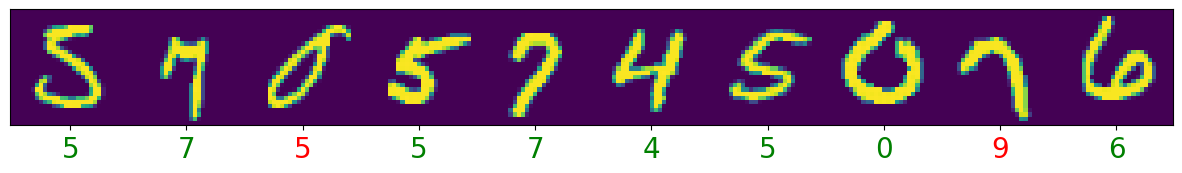

1/1 [==============================] - 0s 36ms/step


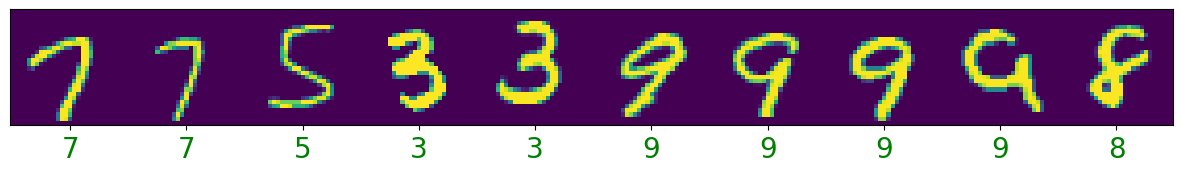

1/1 [==============================] - 0s 19ms/step


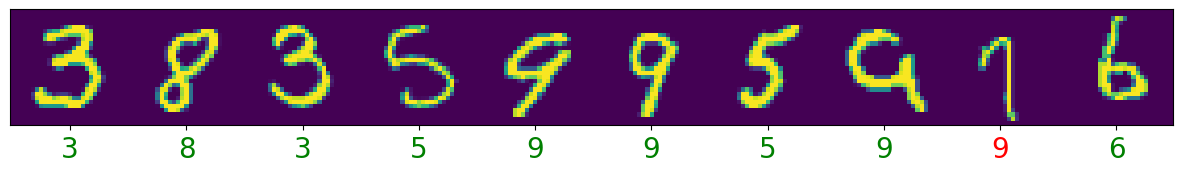

In [42]:
model = get_model()
model.fit(x_train, y_train,
          batch_size=64,
          epochs=20,
          verbose=0,
          callbacks=[VisCallback(x_test, y_test)])

In [44]:
from IPython.display import Image as IPyImage

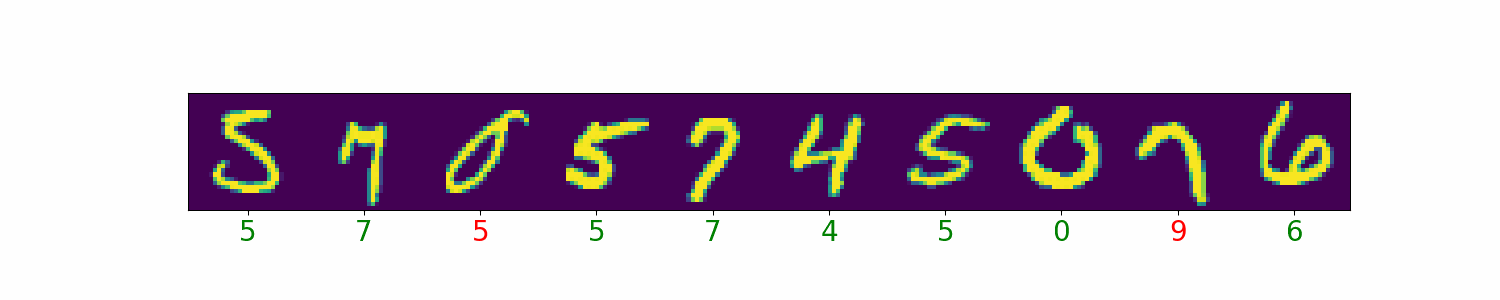

In [45]:
SCALE = 60

# FYI, the format is set to PNG here to bypass checks for acceptable embeddings
IPyImage(GIF_PATH, format='png', width=15 * SCALE, height=3 * SCALE) 